Best match value: 0.6283653974533081 at scale: 1.2105263157894737


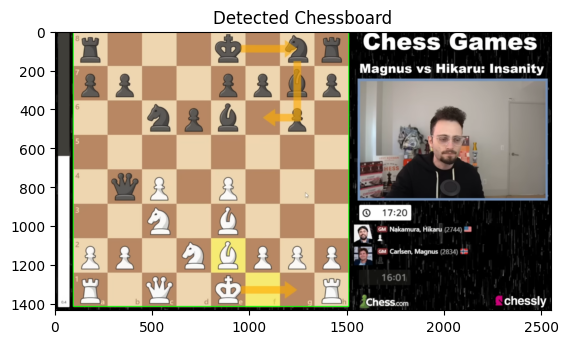

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load images
BOARD_TEMPLATE = cv2.imread('chessboard.png', cv2.IMREAD_COLOR)

def load_images(test_image_path, template_image_path):
    test_image = cv2.imread(test_image_path, cv2.IMREAD_COLOR)
    template = cv2.imread(template_image_path, cv2.IMREAD_COLOR)
    return test_image, template

def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def match_template(test_gray, template_gray, scale_range, threshold=0.5):
    template_h, template_w = template_gray.shape[:2]
    found = None

    # Loop over scales
    for scale in scale_range:
        # Resize the template according to the current scale
        resized_template = cv2.resize(template_gray, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

        # Skip scales where the template is larger than the test image
        if resized_template.shape[0] > test_gray.shape[0] or resized_template.shape[1] > test_gray.shape[1]:
            continue

        # Template Matching using cv2.matchTemplate
        result = cv2.matchTemplate(test_gray, resized_template, cv2.TM_CCOEFF_NORMED)

        # Get the maximum correlation value and its location
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        # Apply threshold to filter out bad matches
        if max_val > threshold:
            # Save the best match found so far
            if found is None or max_val > found[0]:
                found = (max_val, max_loc, scale)

    return found

def visualize_detection(test_image_path, template, found):
    if not found:
        print("No match found")
        return

    (max_val, max_loc, best_scale) = found
    print(f"Best match value: {max_val} at scale: {best_scale}")

    # Reload the test image to reset any drawings from previous runs
    test_image = cv2.imread(test_image_path, cv2.IMREAD_COLOR)

    # Resize the template to the best scale
    best_template = cv2.resize(template, None, fx=best_scale, fy=best_scale, interpolation=cv2.INTER_AREA)

    # Draw a rectangle around the detected area in the test image
    (top_left_x, top_left_y) = max_loc
    bottom_right_x = top_left_x + best_template.shape[1]
    bottom_right_y = top_left_y + best_template.shape[0]

    cv2.rectangle(test_image, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0, 255, 0), 3)

    # Display the result
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.title('Detected Chessboard')
    plt.show()

def main():
    # Load images
    test_image_path = 'test_image.png'
    template_image_path = 'chessboard.png'
    test_image, template = load_images(test_image_path, template_image_path)

    # Convert both images to grayscale
    test_gray = convert_to_grayscale(test_image)
    template_gray = convert_to_grayscale(template)

    # Multi-scale template matching
    scale_range = np.linspace(0.5, 2, 20)  # Narrow down the scale range
    threshold = 0.5  # Threshold for match quality
    found = match_template(test_gray, template_gray, scale_range, threshold)

    # Visualize the detected chessboard
    visualize_detection(test_image_path, template, found)

if __name__ == "__main__":
    main()


In [2]:
%pip install yt-dlp


In [3]:
import os
import subprocess
import sys

# Define a function to run a shell command and capture the output
def run_command(command):
    try:
        result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, shell=True)
        return result.stdout, result.stderr
    except Exception as e:
        print(f"Error running command: {e}")
        sys.exit(1)

# Function to download the video using yt-dlp
def download_video(video_url, output_file="output.mp4"):
    print("Starting video download using yt-dlp...")

    # Set yt-dlp command to download video in 720p quality
    command = f"yt-dlp -f 'bestvideo[height<=720]+bestaudio/best[height<=720]' --merge-output-format mp4 -o {output_file} {video_url}"
    stdout, stderr = run_command(command)

    if "error" in stderr.lower():
        print("An error occurred while downloading the video:")
        print(stderr)
    else:
        print("Video download completed successfully.")
        print(stderr)

    return output_file

# Function to get video information
def get_video_info(file_path):
    print("Getting video information...")

    # Use ffprobe to get video information
    command = f"ffprobe -v quiet -print_format json -show_format -show_streams {file_path}"
    stdout, stderr = run_command(command)

    if stdout:
        print(stdout)
    else:
        print("Error getting video information:")
        print(stderr)

# Main function to execute the download and info retrieval
def main():
    # Replace with your video link
    video_url = "https://www.youtube.com/watch?v=QNcO9CJyDBc"  # Replace this with a valid video URL
    output_file = "downloaded_video_720p.mp4"

    # Step 1: Download the video in 720p using yt-dlp
    downloaded_file = download_video(video_url, output_file)

    # Step 2: Get video information
    get_video_info(downloaded_file)

if __name__ == "__main__":
    main()


Starting video download using yt-dlp...
Video download completed successfully.

Getting video information...
{
    "streams": [
        {
            "index": 0,
            "codec_name": "vp9",
            "codec_long_name": "Google VP9",
            "profile": "Profile 0",
            "codec_type": "video",
            "codec_tag_string": "vp09",
            "codec_tag": "0x39307076",
            "width": 1280,
            "height": 720,
            "coded_width": 1280,
            "coded_height": 720,
            "closed_captions": 0,
            "has_b_frames": 0,
            "sample_aspect_ratio": "1:1",
            "display_aspect_ratio": "16:9",
            "pix_fmt": "yuv420p",
            "level": -99,
            "color_range": "tv",
            "color_space": "bt709",
            "color_transfer": "bt709",
            "color_primaries": "bt709",
            "refs": 1,
            "r_frame_rate": "24000/1001",
            "avg_frame_rate": "4516200/188363",
            "time_

In [4]:
%pip install decord

In [5]:
def extract_frames(video_path, interval=10):
    # Extract frames from the video every 'interval' seconds
    video_capture = cv2.VideoCapture(video_path)
    frames = []

    if not video_capture.isOpened():
        print(f"Error opening video file: {video_path}")
        return frames

    fps = int(video_capture.get(cv2.CAP_PROP_FPS))
    frame_interval = fps * interval

    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Total frames in video: {total_frames}")

    # Loop to extract frames at the specified interval
    current_frame = 0
    while current_frame < total_frames:
        # Set the video position to the desired frame
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame)

        success, frame = video_capture.read()
        if not success:
            break

        frames.append(frame)
        current_frame += frame_interval

    video_capture.release()
    return frames

In [6]:
# Extract frames from the video every 10 seconds
frames = extract_frames("downloaded_video_720p.mp4", interval=10)

Total frames in video: 22581


In [7]:
frames_grayscale = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in frames]

In [8]:
# Load images
test_image_path = 'test_image.png'
template_image_path = 'chessboard.png'
test_image, template = load_images(test_image_path, template_image_path)

# Convert both images to grayscale
test_gray = convert_to_grayscale(test_image)
template_gray = convert_to_grayscale(template)

# Multi-scale template matching
scale_range = np.linspace(0.05, 2, 80)  # Narrow down the scale range
threshold = 0.5  # Threshold for match quality

# Results
matches = []

for frame in frames_grayscale:
    matches.append(match_template(frame, template_gray, scale_range, threshold))

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define a function to visualize matches in a grid
def visualize_matches(matches, template, num_columns=3):
    """
    Visualizes the matches in a grid format.

    Parameters:
    - matches: List of tuples containing frames and match information
    - template: The template image used for matching
    - num_columns: Number of columns in the grid visualization
    """
    num_matches = len(matches)
    num_rows = (num_matches + num_columns - 1) // num_columns  # Calculate required rows

    plt.figure(figsize=(num_columns * 5, num_rows * 5))  # Adjust figure size dynamically

    count = 0
    for frame, found in matches:
        if found:
            (max_val, max_loc, best_scale) = found

            # Resize the template to the best scale
            best_template = cv2.resize(template, None, fx=best_scale, fy=best_scale, interpolation=cv2.INTER_AREA)

            # Draw a rectangle around the detected area in the frame
            (top_left_x, top_left_y) = max_loc
            bottom_right_x = top_left_x + best_template.shape[1]
            bottom_right_y = top_left_y + best_template.shape[0]

            cv2.rectangle(frame, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), (0, 255, 0), 3)

            # Display the result in a grid layout
            plt.subplot(num_rows, num_columns, count + 1)
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f'Match {count + 1}')
            plt.axis('off')
            count += 1

    plt.tight_layout()
    plt.show()


In [10]:
matches

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 (0.6792248487472534, (469, 21), 0.2721518987341772),
 (0.6753201484680176, (469, 21), 0.2721518987341772),
 (0.6672752499580383, (469, 21), 0.2721518987341772),
 (0.6784074306488037, (469, 21), 0.2721518987341772),
 (0.6922376155853271, (469, 21), 0.2721518987341772),
 (0.6941611766815186, (469, 21), 0.2721518987341772),
 (0.6816901564598083, (469, 21), 0.2721518987341772),
 (0.7041300535202026, (469, 21), 0.2721518987341772),
 (0.7069960236549377, (469, 21), 0.2721518987341772),
 None,
 None,
 None,
 None,
 (0.7173972725868225, (469, 21), 0.2721518987341772),
 None,
 None,
 None,
 (0.7065033912658691, (469, 21), 0.2721518987341772),
 (0.7061956524848938, (469, 21), 0.2721518987341772),
 (0.7038497924804688, (469, 21), 0.2721518987341772),
 (0.7172054052352905, (469, 21), 0.2721518987341772),
 (0.7166546583175659, (469, 21), 0.2721518987341772),
 (0.7360303997993469, (469, 21), 0.2721518987341772),
 (0.7355949282646179, (469, 21)

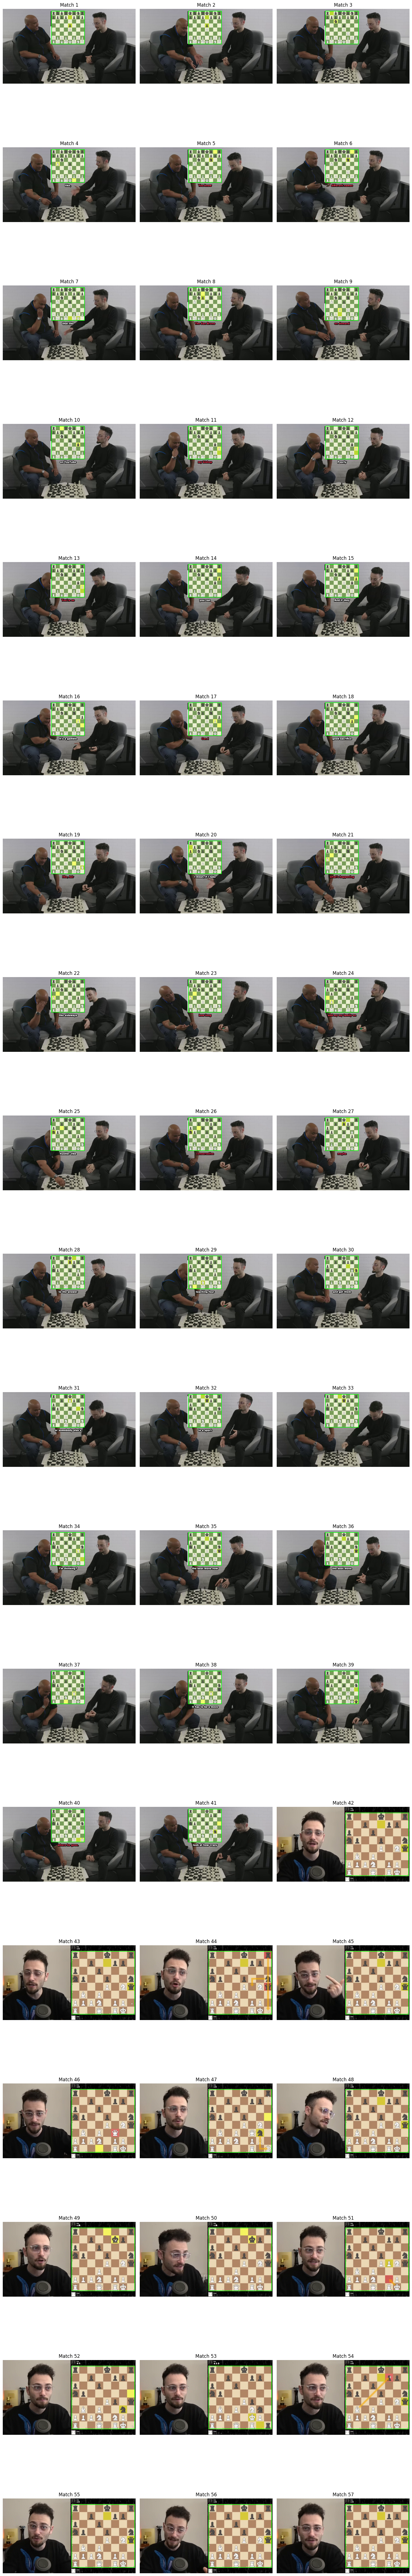

In [11]:
visualize_matches(list(zip(frames, matches)), template, num_columns=3)